**Boneage Prediction Using Deep Learning**

- Predict The age from X-Ray images of wrist.

- Dataset is part of RSNA(The Radiological Society of North America) challenge to predict the age from X-ray images.

- This dataset is available in Kaggle too as:
  (https://www.kaggle.com/kmader/rsna-bone-age)
  
-  Model Evaluation : Model is evaluated using MAE(Mean Absolute Error) as a metric.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import urllib.request
import sys
import time
import urllib
#Download the Dataset
urllib.request.urlretrieve('https://storage.googleapis.com/kaggle-data-sets/10832/15122/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1571145365&Signature=M3wbTC1g9%2BDA3Wh8m39uAdR7nJH9KVEh4teFCTbQcFNswC7qgUGqFxrJUm91dVLhxnDzb67tM1o0ZyoolmdhRnWPJWwpVc36gdgI5yaQ1ajzzNJnF3Vi27Wosq%2FhYAvIxbuwdR9WvvU5FNzcyKGk%2B2Vi4qe1m6IwuOpZwmh%2Fo66cbOIsFJI%2FJW0%2FEQYu9x7JjVaZwKopu2%2BFE%2FzrGxnVziCeTa%2Bj0k%2FgylW%2B3zfSo2ohSjhv95d6IwNar9%2BX5e3kVO7%2FI3IzviWWGyS2GZOy0KTjlsNTq2ayPrwVmMVpucnZOF74MpZl%2B7GE4rCiNhzqA2pgOCcEQFTecckeRIoMuw%3D%3D&response-content-disposition=attachment%3B+filename%3Drsna-bone-age.zip', 'rsna-bone-age.zip')

('rsna-bone-age.zip', <http.client.HTTPMessage at 0x7fcc45437588>)

In [ ]:
#Unzip the dataset
!unzip rsna-bone-age.zip

In [0]:
df = pd.read_csv('boneage-training-dataset.csv')
df.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


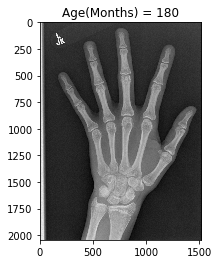

In [0]:
#Load Sample Image
import cv2
image = cv2.imread('boneage-training-dataset/boneage-training-dataset/'+str(df['id'].values[0])+'.png')
plt.imshow(image)
plt.title('Age(Months) = '+str(df['boneage'].values[0]))
plt.show()

In [0]:
image.shape

(2044, 1514, 3)

In [0]:
df.shape

(12611, 3)

In [0]:
#Load All The Train Images
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm

import cv2
import imutils
img_arr = []

for i in tqdm(range(0,df.shape[0])):
  image = cv2.imread('boneage-training-dataset/boneage-training-dataset/'+str(df.loc[i]['id'])+'.png')
  img = cv2.resize(image,(128,128))
  img_arr.append(img)

100%|██████████| 12611/12611 [06:12<00:00, 30.87it/s]


In [0]:
male_arr = []
for i in range(df.shape[0]):
  if(df.loc[i]['male']==True):
    male_arr.append(1)
  else:
    male_arr.append(0)
df['male_encoded'] = male_arr

In [0]:
#I will use first 10k points for training and last 2.6k points for test
y_train = df[['boneage','male_encoded']].head(10000)
y_test = df[['boneage','male_encoded']].tail(2611)

In [0]:
y_train['male_encoded'].value_counts()

1    5430
0    4570
Name: male_encoded, dtype: int64

In [0]:
y_test['male_encoded'].value_counts()

1    1403
0    1208
Name: male_encoded, dtype: int64

**This is not too Imbalanced Dataset**

In [0]:
#Creating Train Images
import numpy as np
img_rows, img_cols = 128, 128
x_train = np.array(img_arr[:10000]).reshape(len(img_arr[:10000]), img_rows, img_cols,3)

x_train = x_train.astype('float32')
x_train /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

x_train shape: (10000, 128, 128, 3)
10000 train samples


In [0]:
#Creating Test Images
img_rows, img_cols = 128, 128
x_test = np.array(img_arr[10000:]).reshape(len(img_arr[10000:]), img_rows, img_cols,3)

x_test = x_test.astype('float32')
x_test /= 255
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')
input_shape = (img_rows, img_cols, 3)

x_test shape: (2611, 128, 128, 3)
2611 test samples


**Simple CNN model**

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization

from keras.layers import Dense, Dropout, Flatten
from keras.models import Model


In [0]:
img_input = Input(shape=(input_shape))

x = Conv2D(128, kernel_size=(3, 3),activation='relu')(img_input)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = Dropout(0.25)(x)


x = Conv2D(32, (3, 3), activation='relu')(x)

x = Dropout(0.15)(x)

x = Flatten()(x)


x = Dense(128, activation='relu')(x)


x = Dense(64, activation='relu')(x)

classifier = Dense(1, activation='sigmoid',name='classifier')(x)

regressor = Dense(1, activation='linear',name='regressor')(x)

model = Model(inputs=img_input, outputs=[classifier, regressor])
model.summary()



Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 126, 126, 128 3584        input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 124, 124, 64) 73792       conv2d_36[0][0]                  
__________________________________________________________________________________________________
dropout_24 (Dropout)            (None, 124, 124, 64) 0           conv2d_37[0][0]                  
___________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop',
              loss={'classifier': 'binary_crossentropy', 'regressor': 'mean_squared_error'},
               metrics = {"classifier": 'acc',"regressor": 'mae'} )

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_regressor_mean_absolute_error', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(x_train,
	{"classifier": y_train['male_encoded'].values, "regressor": y_train['boneage'].values},
  validation_data = (x_test,
  {"classifier": y_test['male_encoded'].values, "regressor": y_test['boneage']}),epochs=50,batch_size=128,verbose=1,callbacks=[es])

Train on 10000 samples, validate on 2611 samples
Epoch 1/50
10000/10000 [==============================] - 94s 9ms/step - loss: 8426.3272 - classifier_loss: 2.6877 - regressor_loss: 8423.6394 - classifier_acc: 0.4782 - regressor_mean_absolute_error: 57.5191 - val_loss: 1430.7292 - val_classifier_loss: 0.9794 - val_regressor_loss: 1429.7498 - val_classifier_acc: 0.5079 - val_regressor_mean_absolute_error: 30.9302
Epoch 2/50
10000/10000 [==============================] - 92s 9ms/step - loss: 2363.4049 - classifier_loss: 1.1525 - regressor_loss: 2362.2524 - classifier_acc: 0.4962 - regressor_mean_absolute_error: 39.0407 - val_loss: 5215.1626 - val_classifier_loss: 1.6767 - val_regressor_loss: 5213.4859 - val_classifier_acc: 0.5259 - val_regressor_mean_absolute_error: 63.4481
Epoch 3/50
10000/10000 [==============================] - 91s 9ms/step - loss: 2120.4111 - classifier_loss: 0.9169 - regressor_loss: 2119.4942 - classifier_acc: 0.5055 - regressor_mean_absolute_error: 37.0751 - val_lo

In [0]:
out1,out2 = model.predict(x_test)
age_out = []
for i in out1:
  if(i>=0.5):
    age_out.append(1)
  else:
    age_out.append(0)

In [0]:
y_test['pred_boneage']=np.round(out2)
y_test['pred_male'] = age_out
y_test

,boneage,male_encoded,pred_boneage,pred_male
10000,108,1,123.0,1
10001,94,0,128.0,1
10002,132,0,126.0,1
10003,106,0,129.0,1
10004,120,0,126.0,1
10005,144,0,128.0,1
10006,186,1,134.0,1
10007,192,1,129.0,1
10008,82,0,129.0,1
10009,82,0,122.0,0


**Using InceptionNet**

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

#Set base model as Inception V3 with weights initialized to imagenet and set top layers false and image size=128x128x3
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(128, 128, 3))

In [0]:
from keras.layers import Dense, Dropout, Flatten
incep_model = Model(base_model.input,base_model.layers[-2].output)


x = incep_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)


classifier = Dense(1, activation='softmax',name='classifier')(x)

regressor = Dense(1, activation='linear',name='regressor')(x)

model = Model(inputs=base_model.input, outputs=[classifier, regressor])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 63, 63, 32)   864         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 63, 63, 32)   96          conv2d_133[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 63, 63, 32)   0           batch_normalization_95[0][0]     
___________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop',
              loss={'classifier': 'binary_crossentropy', 'regressor': 'mean_squared_error'},
               metrics = {"classifier": 'acc',"regressor": 'mae'} )

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_regressor_mean_absolute_error', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(x_train,
	{"classifier": y_train['male_encoded'].values, "regressor": y_train['boneage'].values},
  validation_data = (x_test,
  {"classifier": y_test['male_encoded'].values, "regressor": y_test['boneage']}),epochs=50,batch_size=128,verbose=1,callbacks=[es])

Train on 10000 samples, validate on 2611 samples
Epoch 1/50
10000/10000 [==============================] - 79s 8ms/step - loss: 2983.5092 - classifier_loss: 7.2857 - regressor_loss: 2976.2235 - classifier_acc: 0.5430 - regressor_mean_absolute_error: 42.2009 - val_loss: 3675587.2112 - val_classifier_loss: 7.3759 - val_regressor_loss: 3675579.8461 - val_classifier_acc: 0.5373 - val_regressor_mean_absolute_error: 1600.9094
Epoch 2/50
10000/10000 [==============================] - 59s 6ms/step - loss: 1298.9560 - classifier_loss: 7.2857 - regressor_loss: 1291.6703 - classifier_acc: 0.5430 - regressor_mean_absolute_error: 28.1281 - val_loss: 32435.6387 - val_classifier_loss: 7.3759 - val_regressor_loss: 32428.2627 - val_classifier_acc: 0.5373 - val_regressor_mean_absolute_error: 176.6390
Epoch 3/50
10000/10000 [==============================] - 59s 6ms/step - loss: 894.1497 - classifier_loss: 7.2857 - regressor_loss: 886.8640 - classifier_acc: 0.5430 - regressor_mean_absolute_error: 23.4117

In [0]:
out1,out2 = model.predict(x_test)
gen_out = []
for i in out1:
  if(i>=0.5):
    gen_out.append(1)
  else:
    gen_out.append(0)

In [0]:
y_test['pred_boneage']=np.round(out2)
y_test['pred_male'] = age_out
y_test

,boneage,male_encoded,pred_boneage,pred_male
10000,108,1,112.0,1
10001,94,0,113.0,1
10002,132,0,149.0,1
10003,106,0,120.0,1
10004,120,0,106.0,1
10005,144,0,129.0,1
10006,186,1,172.0,1
10007,192,1,167.0,1
10008,82,0,88.0,1
10009,82,0,92.0,0


In [0]:
#Average Age Difference between Predicted Age and Original Age

dif = 0
pred_age = list(y_test['pred_boneage'])
ori_age = list(y_test['boneage'])
for i in range(y_test.shape[0]):
  x = abs(pred_age[i]-ori_age[i])
  dif = dif+x
  
print("Average Difference between Predicted and Original Age(Months) = ",dif/y_test.shape[0])

Average Difference between Predicted and Original Age(Months) =  15.16621983914209


In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test['male_encoded'],y_test['pred_male'])

array([[ 228,  980],
       [ 305, 1098]])

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test['male_encoded'],y_test['pred_male'])

0.5078513979318269

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test['male_encoded'],y_test['pred_male']))

              precision    recall  f1-score   support

           0       0.43      0.19      0.26      1208
           1       0.53      0.78      0.63      1403

    accuracy                           0.51      2611
   macro avg       0.48      0.49      0.45      2611
weighted avg       0.48      0.51      0.46      2611



**Observations :**

 - here it's clear that from confusion matrix that the model is overfitting.
 - So it is difficult to predict Gender from the wrist X-rays.
 - So I'll use Gender also as an input to the model.

**Using Inception Net with multiple inputs**

In [0]:
#Creating Train Images
import numpy as np
img_rows, img_cols = 128, 128
x_train = np.array(img_arr[:10000]).reshape(len(img_arr[:10000]), img_rows, img_cols,3)

x_train = x_train.astype('float32')
x_train /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

x_train shape: (10000, 128, 128, 3)
10000 train samples


In [0]:
#Creating Test Images
img_rows, img_cols = 128, 128
x_test = np.array(img_arr[10000:]).reshape(len(img_arr[10000:]), img_rows, img_cols,3)

x_test = x_test.astype('float32')
x_test /= 255
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')
input_shape = (img_rows, img_cols, 3)

x_test shape: (2611, 128, 128, 3)
2611 test samples


In [0]:
y_train = df['boneage'].head(10000).values
y_test = df['boneage'].tail(2611).values

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(128, 128, 3))

In [0]:
from keras.layers import Dense, Dropout, Flatten, concatenate
incep_model = Model(base_model.input,base_model.layers[-2].output)


x = incep_model.output
x = GlobalAveragePooling2D()(x)

inp_gen = Input(shape=(1,), name='input_gender')
y = Dense(32, activation="relu")(inp_gen)
y = Dense(16, activation="relu")(y)

x = concatenate([x, y], axis=1)


x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)

out = Dense(1, activation='linear')(x)

model = Model(inputs=[base_model.input,inp_gen], outputs=[out])
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_227 (Conv2D)             (None, 63, 63, 32)   864         input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 63, 63, 32)   96          conv2d_227[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 63, 63, 32)   0           batch_normalization_189[0][0]    
___________________________________________________________________________________________

In [0]:
model.compile(optimizer='Adam',loss='mean_squared_error',metrics = ['mae'])

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [0]:
gen_train = df['male_encoded'].head(10000).values
gen_test = df['male_encoded'].tail(2611).values

In [0]:
history = model.fit([x_train,gen_train],y_train,validation_data=([x_test,gen_test],y_test),epochs = 50,batch_size=128,verbose=1,callbacks=[es])

Train on 10000 samples, validate on 2611 samples
Epoch 1/50
10000/10000 [==============================] - 87s 9ms/step - loss: 3657.4673 - mean_absolute_error: 45.5952 - val_loss: 683774.1848 - val_mean_absolute_error: 389.9827
Epoch 2/50
10000/10000 [==============================] - 60s 6ms/step - loss: 990.6737 - mean_absolute_error: 23.8115 - val_loss: 10375.0507 - val_mean_absolute_error: 94.3101
Epoch 3/50
10000/10000 [==============================] - 60s 6ms/step - loss: 727.1773 - mean_absolute_error: 20.4586 - val_loss: 8327.7439 - val_mean_absolute_error: 84.4336
Epoch 4/50
10000/10000 [==============================] - 60s 6ms/step - loss: 590.5332 - mean_absolute_error: 18.6577 - val_loss: 4086.2824 - val_mean_absolute_error: 58.5585
Epoch 5/50
10000/10000 [==============================] - 60s 6ms/step - loss: 461.8325 - mean_absolute_error: 16.6043 - val_loss: 1191.7965 - val_mean_absolute_error: 23.3698
Epoch 6/50
10000/10000 [==============================] - 60s 6ms/

In [0]:
out1 = model.predict([x_test,gen_test])

In [0]:
df_temp = pd.DataFrame(columns=['Original_age','pred_age'])
df_temp['Original_age'] = y_test
df_temp['pred_age'] = np.round(out1)
df_temp.head(10)

,Original_age,pred_age
0,108,109.0
1,94,87.0
2,132,145.0
3,106,117.0
4,120,98.0
5,144,143.0
6,186,186.0
7,192,186.0
8,82,104.0
9,82,99.0


In [0]:
#Average Age Difference between Predicted Age and Original Age

dif = 0
pred_age = list(df_temp['pred_age'])
ori_age = list(df_temp['Original_age'])
for i in range(y_test.shape[0]):
  x = abs(pred_age[i]-ori_age[i])
  dif = dif+x
  
print("Average Difference between Predicted and Original Age(Months) = ",dif/y_test.shape[0])

Average Difference between Predicted and Original Age(Months) =  11.54538490999617


  Now The Average difference between predicted and original age(months) has reduced.

**Using DenseNet**

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(128, 128, 3))

In [0]:
from keras.layers import Dense, Dropout, Flatten, concatenate
dense_net = Model(base_model.input,base_model.output)


x = dense_net.output
x = GlobalAveragePooling2D()(x)

inp_gen = Input(shape=(1,), name='input_gender')
y = Dense(32, activation="relu")(inp_gen)
y = Dense(16, activation="relu")(y)

x = concatenate([x, y], axis=1)


x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)

x = Dense(128, activation='relu')(x)


x = Dense(64, activation='relu')(x)

x = Dense(32, activation='relu')(x)



out = Dense(1, activation='linear')(x)

model = Model(inputs=[base_model.input,inp_gen], outputs=[out])
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 3)  0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [0]:
model.compile(optimizer='Adam',loss='mean_squared_error',metrics = ['mae'])

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [0]:
gen_train = df['male_encoded'].head(10000).values
gen_test = df['male_encoded'].tail(2611).values

In [0]:
history = model.fit([x_train,gen_train],y_train,validation_data=([x_test,gen_test],y_test),epochs = 100,batch_size=64,verbose=1,callbacks=[es])

Train on 10000 samples, validate on 2611 samples
Epoch 1/100
10000/10000 [==============================] - 160s 16ms/step - loss: 1228.5125 - mean_absolute_error: 23.3442 - val_loss: 1093.8459 - val_mean_absolute_error: 29.4597
Epoch 2/100
10000/10000 [==============================] - 110s 11ms/step - loss: 326.8260 - mean_absolute_error: 14.2264 - val_loss: 214.9490 - val_mean_absolute_error: 11.8239
Epoch 3/100
10000/10000 [==============================] - 109s 11ms/step - loss: 289.7934 - mean_absolute_error: 13.3924 - val_loss: 269.2073 - val_mean_absolute_error: 12.8925
Epoch 4/100
10000/10000 [==============================] - 110s 11ms/step - loss: 262.4605 - mean_absolute_error: 12.7539 - val_loss: 1854.5717 - val_mean_absolute_error: 36.8973
Epoch 5/100
10000/10000 [==============================] - 110s 11ms/step - loss: 320.6655 - mean_absolute_error: 14.1305 - val_loss: 295.2685 - val_mean_absolute_error: 14.1280
Epoch 6/100
10000/10000 [==============================] -

In [0]:
model.evaluate([x_test,gen_test],y_test,verbose=1,batch_size=64)

2611/2611 [==============================] - 8s 3ms/step


[210.52993517860696, 11.53552638521052]

In [0]:
out1 = model.predict([x_test,gen_test])

In [0]:
df_temp = pd.DataFrame(columns=['Original_age','pred_age'])
df_temp['Original_age'] = y_test
df_temp['pred_age'] = np.round(out1)
df_temp.head(10)

,Original_age,pred_age
0,108,116.0
1,94,98.0
2,132,137.0
3,106,113.0
4,120,104.0
5,144,139.0
6,186,168.0
7,192,160.0
8,82,89.0
9,82,93.0


In [0]:
#Average Age Difference between Predicted Age and Original Age

dif = 0
pred_age = list(df_temp['pred_age'])
ori_age = list(df_temp['Original_age'])
for i in range(y_test.shape[0]):
  x = abs(pred_age[i]-ori_age[i])
  dif = dif+x
  
print("Average Difference between Predicted and Original Age(Months) = ",dif/y_test.shape[0])

Average Difference between Predicted and Original Age(Months) =  11.53887399463807


**Some Pre-Processing On Image**

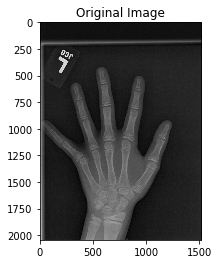

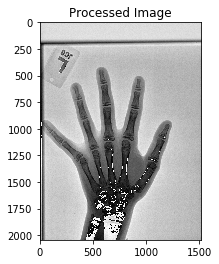

In [0]:
k = 10
#Load Sample Image
import cv2
image = cv2.imread('boneage-training-dataset/boneage-training-dataset/'+str(df['id'].values[k])+'.png')

plt.imshow(image)
plt.title('Original Image')
plt.show()

#Taking negative of image
image1 = cv2.bitwise_not(image)

#Substract original from negative
image = image1-image

plt.imshow(image)
plt.title('Processed Image')
plt.show()

In [0]:
#Load All The Train Images
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm

import cv2
import imutils
img_arr = []

for i in tqdm(range(0,df.shape[0])):
  image = cv2.imread('boneage-training-dataset/boneage-training-dataset/'+str(df.loc[i]['id'])+'.png')
  
  image1 = cv2.bitwise_not(image)
  image = image1-image
  
  img = cv2.resize(image,(256,256))
  img_arr.append(img)

100%|██████████| 12611/12611 [06:22<00:00, 32.96it/s]


In [0]:
male_arr = []
for i in range(df.shape[0]):
  if(df.loc[i]['male']==True):
    male_arr.append(1)
  else:
    male_arr.append(0)
df['male_encoded'] = male_arr

In [0]:
#Creating Train Images
import numpy as np
img_rows, img_cols = 256, 256
x_train = np.array(img_arr[:10000]).reshape(len(img_arr[:10000]), img_rows, img_cols,3)

x_train = x_train.astype('float32')
x_train /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
input_shape = (img_rows, img_cols, 3)

x_train shape: (10000, 256, 256, 3)
10000 train samples


In [0]:
#Creating Test Images
img_rows, img_cols = 256, 256
x_test = np.array(img_arr[10000:]).reshape(len(img_arr[10000:]), img_rows, img_cols,3)

x_test = x_test.astype('float32')
x_test /= 255
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')
input_shape = (img_rows, img_cols, 3)

x_test shape: (2611, 256, 256, 3)
2611 test samples


In [0]:
y_train = df['boneage'].head(10000).values
y_test = df['boneage'].tail(2611).values

**Using InceptionV3 Model**

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(256, 256, 3))

In [0]:
from keras.layers import Dense, Dropout, Flatten, concatenate, Input
incep_model = Model(base_model.input,base_model.layers[-2].output)


x = incep_model.output
x = GlobalAveragePooling2D()(x)

inp_gen = Input(shape=(1,), name='input_gender')
y = Dense(32, activation="relu")(inp_gen)
y = Dense(16, activation="relu")(y)

x = concatenate([x, y], axis=1)


x = Dense(1024, activation='relu')(x)
#x = Dropout(0.25)(x)

x = Dense(512, activation='relu')(x)
#x = Dropout(0.25)(x)

out = Dense(1, activation='linear')(x)

model = Model(inputs=[base_model.input,inp_gen], outputs=[out])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 127, 127, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 127, 127, 32) 0           batch_normalization_95[0][0]     
___________________________________________________________________________________________

In [0]:
model.compile(optimizer='Adam',loss='mean_squared_error',metrics = ['mae'])

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [0]:
gen_train = df['male_encoded'].head(10000).values
gen_test = df['male_encoded'].tail(2611).values

In [0]:
history = model.fit([x_train,gen_train],y_train,validation_data=([x_test,gen_test],y_test),epochs = 100,batch_size=64,verbose=1,callbacks=[es])

Train on 10000 samples, validate on 2611 samples
Epoch 1/100
10000/10000 [==============================] - 271s 27ms/step - loss: 1112.2329 - mean_absolute_error: 17.0610 - val_loss: 150.9641 - val_mean_absolute_error: 9.6768
Epoch 2/100
10000/10000 [==============================] - 248s 25ms/step - loss: 88.7320 - mean_absolute_error: 7.3415 - val_loss: 142.6634 - val_mean_absolute_error: 9.3745
Epoch 3/100
10000/10000 [==============================] - 248s 25ms/step - loss: 70.8749 - mean_absolute_error: 6.6937 - val_loss: 205.5967 - val_mean_absolute_error: 11.1834
Epoch 4/100
10000/10000 [==============================] - 248s 25ms/step - loss: 73.3121 - mean_absolute_error: 6.7736 - val_loss: 137.3128 - val_mean_absolute_error: 9.2199
Epoch 5/100
10000/10000 [==============================] - 248s 25ms/step - loss: 48.6735 - mean_absolute_error: 5.5085 - val_loss: 227.5386 - val_mean_absolute_error: 12.2311
Epoch 6/100
10000/10000 [==============================] - 248s 25ms/st

In [0]:
model.save("/content/drive/My Drive/model_boneage.h5")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
model.evaluate([x_test,gen_test],y_test,verbose=1,batch_size=64)

2611/2611 [==============================] - 18s 7ms/step


[110.34555841779763, 7.997245776703512]

In [0]:
out1 = model.predict([x_test,gen_test])
df_temp = pd.DataFrame(columns=['Original_age','pred_age'])
df_temp['Original_age'] = y_test
df_temp['pred_age'] = np.round(out1)
df_temp.head(20)

,Original_age,pred_age
0,108,103.0
1,94,91.0
2,132,142.0
3,106,113.0
4,120,102.0
5,144,146.0
6,186,189.0
7,192,185.0
8,82,79.0
9,82,105.0


In [0]:
df_temp.to_csv('/content/drive/My Drive/pred_age.csv',index=False)

In [0]:
import cv2
def display_results(k):
  image = cv2.imread('boneage-training-dataset/boneage-training-dataset/'+str(df['id'].values[k+10000])+'.png')
  print("Original Age = ",df.loc[10000+k]['boneage'])
  plt.imshow(image)
  plt.title('Original Image')
  plt.show()
  print('predicted age = ', df_temp.loc[k]['pred_age'])

**Sample Cases**

Some Good Results : 
Original Age =  144


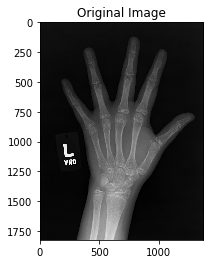

predicted age =  146.0


Original Age =  162


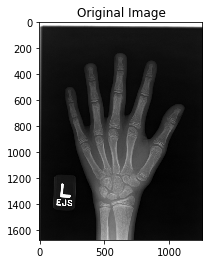

predicted age =  161.0


Original Age =  156


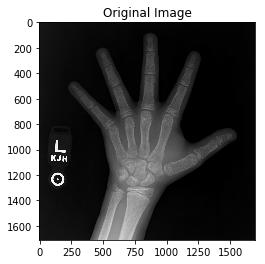

predicted age =  158.0


Original Age =  120


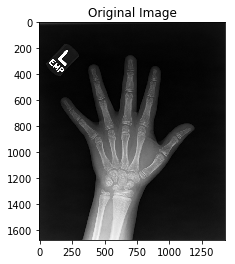

predicted age =  121.0


Original Age =  132


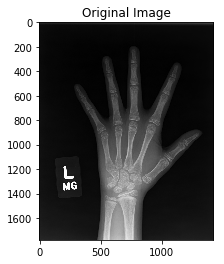

predicted age =  130.0


Original Age =  156


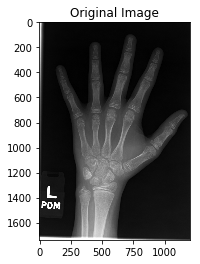

predicted age =  157.0


Original Age =  168


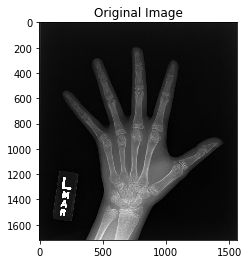

predicted age =  166.0


Original Age =  174


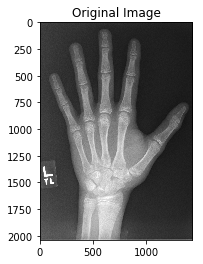

predicted age =  172.0


Original Age =  156


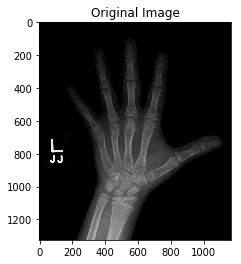

predicted age =  156.0


Original Age =  156


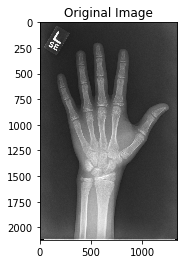

predicted age =  156.0




In [0]:
print("Some Good Results : ")
disp = 0
for i in range(0,df_temp.shape[0]):
  if(abs(df_temp.loc[i]['pred_age']-df_temp.loc[i]['Original_age'])<=2):
    display_results(i)
    disp+=1
    print('\n')
    print('='*100)
  if(disp==10):
    break;


**Some Failure Cases**

Some Bad Results : 
Original Age =  120


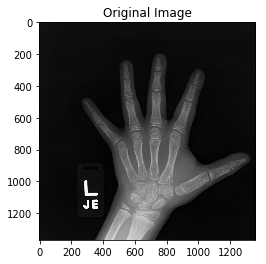

predicted age =  102.0


Original Age =  82


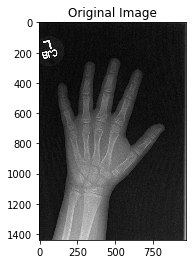

predicted age =  105.0


Original Age =  94


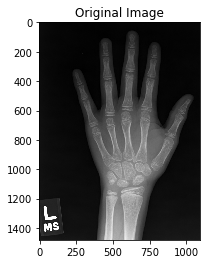

predicted age =  109.0


Original Age =  94


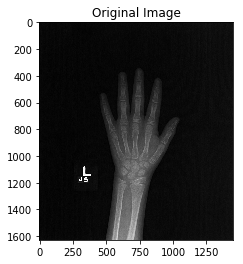

predicted age =  115.0


Original Age =  204


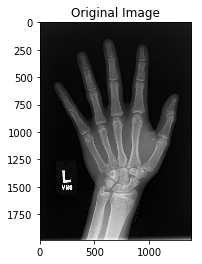

predicted age =  188.0


Original Age =  94


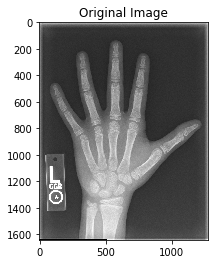

predicted age =  115.0


Original Age =  132


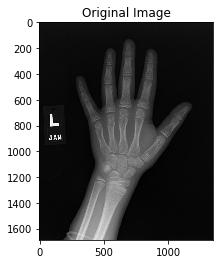

predicted age =  116.0


Original Age =  106


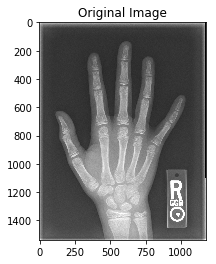

predicted age =  127.0


Original Age =  150


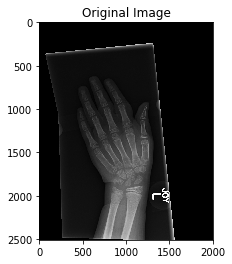

predicted age =  119.0


Original Age =  150


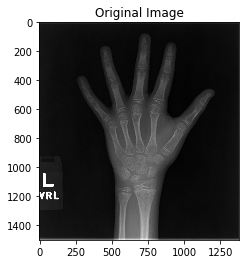

predicted age =  115.0




In [0]:
print("Some Bad Results : ")
disp = 0
for i in range(0,df_temp.shape[0]):
  if(abs(df_temp.loc[i]['pred_age']-df_temp.loc[i]['Original_age'])>=15):
    display_results(i)
    disp+=1
    print('\n')
    print('='*100)
  if(disp==10):
    break;


**This is a better result now Compared to previos one with no pre-processing. Further processing of images could help reduce the MAE.**

## Conclusion

- > It is difficult to predict Gender from X-ray Of hand.
    Models did not do good job.
    
- > Using some preprocessing on image to sharpen the light color areas helped bringing down the MAE to 7.99.

- > When sharpened the image, the joints became a bit clear. So Joints in X-Ray play an important role in determining the age.

- > However More processing on the images could definitely improve the model's performance.